In [235]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
from glob import glob

"""Change to the data folder"""
new_path = "./new_train/new_train"

# number of sequences in each dataset
# train:205942  val:3200 test: 36272 
# sequences sampled at 10HZ rate

### Create a dataset class 

In [236]:
class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, data_path: str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.data_path = data_path
        self.transform = transform

        self.pkl_list = glob(os.path.join(self.data_path, '*'))
        self.pkl_list.sort()
        
    def __len__(self):
        return len(self.pkl_list)

    def __getitem__(self, idx):

        pkl_path = self.pkl_list[idx]
        with open(pkl_path, 'rb') as f:
            data = pickle.load(f)
            
        if self.transform:
            data = self.transform(data)

        return data


# intialize a dataset
val_dataset  = ArgoverseDataset(data_path=new_path)

### Create a loader to enable batch processing

In [237]:
batch_sz = 64

def my_collate(batch):
    """ collate lists of samples into batches, create [ batch_sz x agent_sz x seq_len x feature] """
    inp = [numpy.dstack([scene['p_in'], scene['v_in']]) for scene in batch]
    out = [numpy.dstack([scene['p_out'], scene['v_out']]) for scene in batch]
    scene_ids = [scene['scene_idx'] for scene in batch]
    inp = torch.LongTensor(inp)
    out = torch.LongTensor(out)
    scene_ids = torch.LongTensor(scene_ids)
    return [inp, out, scene_ids]

def test_collate(batch):
    """ collate lists of samples into batches, create [ batch_sz x agent_sz x seq_len x feature] """
    inp = [numpy.dstack([scene['p_in'], scene['v_in']]) for scene in batch]
    scene_ids = [scene['scene_idx'] for scene in batch]
    inp = torch.LongTensor(inp)
    scene_ids = torch.LongTensor(scene_ids)
    return [inp, scene_ids]

val_loader = DataLoader(val_dataset,batch_size=batch_sz, shuffle = False, collate_fn=my_collate, num_workers=0)

### Visualize the batch of sequences


torch.Size([64, 60, 30, 4])


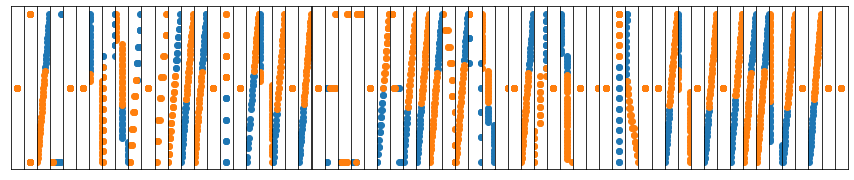

In [238]:
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm, trange

agent_id = 0

def show_sample_batch(sample_batch, agent_id):
    """visualize the trajectory for a batch of samples with a randon agent"""
    inp, out, scene_ids = sample_batch
    batch_sz = inp.size(0)
    agent_sz = inp.size(1)
    
    fig, axs = plt.subplots(1,batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()   
    for i in range(batch_sz):
        axs[i].xaxis.set_ticks([])
        axs[i].yaxis.set_ticks([])
        
        # first two feature dimensions are (x,y) positions
        axs[i].scatter(inp[i, agent_id,:,0], inp[i, agent_id,:,1])
        axs[i].scatter(out[i, agent_id,:,0], out[i, agent_id,:,1])

cuda_status = torch.cuda.is_available()

model = torch.nn.Sequential(
    torch.nn.Linear(76, 98),
    torch.nn.ReLU(),
    torch.nn.Linear(98, 98),
    torch.nn.ReLU(),
    torch.nn.Linear(98, 98),
    torch.nn.ReLU(),
    torch.nn.Linear(98, 120)
)

# Use the nn package to define our loss function
loss_fn=torch.nn.MSELoss()

# Use the optim package to define an Optimizer

learning_rate =1e-3
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

        
for i_batch, sample_batch in enumerate(val_loader):
    inp, out, scene_ids = sample_batch
    """TODO:
      Deep learning model
      training routine
    """
    inp = torch.flatten(inp, start_dim=2)

    if cuda_status:
        model = model.cuda()
        x = inp.cuda()
        y = out.cuda()
    else:
        x = inp
        y = out
    
    y_pred = None
    
    for t in tqdm(range(100), desc='Interation'):
        
        # Forward pass: predict y by passing x to the model.    
        y_pred = model(x.float())
        y_pred = torch.reshape(y_pred, torch.Size([batch_sz, 60, 30, 4]))
        
        # Compute the loss.
        loss = loss_fn(y_pred, y.float())
        
        # Before backward pass, zero outgradients to clear buffers  
        optimizer.zero_grad()
        
        # Backward pass: compute gradient w.r.t modelparameters
        loss.backward()
    
        # makes an gradient descent step to update its parameters
        optimizer.step()
    
    print(y_pred.shape)
    show_sample_batch(sample_batch, agent_id)
    break

In [242]:
import pandas as pd

# Submission output
writeCSV = True
val_path = "./new_val_in/new_val_in"

if writeCSV:
    
    dataset = ArgoverseDataset(data_path=val_path)
    test_loader = DataLoader(dataset,batch_size=batch_sz, shuffle = False, collate_fn=test_collate, num_workers=0)
    
    data = []
    
    with torch.no_grad():
        #with tqdm(test_loader, unit="batch") as batches:
        for i_batch, sample_batch in enumerate(test_loader):
            inp, scene_ids = sample_batch
            inp = torch.flatten(inp, start_dim=2)

            if cuda_status:
                model = model.cuda()
                x = inp.cuda()
            else:
                x = inp

            y_pred = None

            # Forward pass: predict y by passing x to the model.    
            y_pred = model(x.float())
            y_pred = torch.reshape(y_pred, torch.Size([batch_sz, 60, 30, 4]))

            for i in range(batch_sz):
                row = []
                row.append(scene_ids[i].item())
                curr = y_pred[i]
                for j in range(60):
                    row.append(str(curr[j][29][0].item()) + ' ' + str(curr[j][29][1].item()))
                data.append(row)

    df = pd.DataFrame(data, columns = ['ID','v1','v2','v3','v4','v5','v6','v7','v8','v9','v10','v11','v12','v13','v14','v15','v16','v17','v18','v19','v20','v21','v22','v23','v24','v25','v26','v27','v28','v29','v30','v31','v32','v33','v34','v35','v36','v37','v38','v39','v40','v41','v42','v43','v44','v45','v46','v47','v48','v49','v50','v51','v52','v53','v54','v55','v56','v57','v58','v59','v60'])
    df.to_csv('submission.csv')
                
                
                